In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.font_manager as fm
import matplotlib as mlp
mlp.rcParams["axes.unicode_minus"] = False

from sklearn.ensemble import RandomForestClassifier      # 앙상블

from sklearn.model_selection import train_test_split     # 훈련용과 테스트용으로 데이터 분할

from sklearn.metrics import classification_report, roc_curve
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

import xgboost as xgb ## XGBoost 불러오기
from xgboost import plot_importance ## Feature Importance를 불러오기 위함

import joblib

import warnings
warnings.filterwarnings('ignore')

# data load

In [2]:
coating = pd.read_csv("data/HQ_coating.csv")
sheet_metal = pd.read_csv("data/HQ_sheet_metal.csv")
exchange = pd.read_csv("data/HQ_exchange.csv")

In [17]:
coating = coating[coating["HQ"]<=4]
sheet_metal = sheet_metal[sheet_metal["HQ"]<=4]
exchange = exchange[exchange["HQ"]<=4]

### 오차 행렬 함수 정의

In [4]:
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    F1 = f1_score(y_test, y_pred, average='macro')
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))

# Coating

In [18]:
X = coating[["part", "damage", "supercategory_name"]]
y = coating[["HQ"]]

X_dummy = pd.get_dummies(X)
X_dummy.columns = ['Bonnet', 'Bumper', 'Door', 'Fender', 'Head lights', 
                   'Rear lamp', 'Rocker panel', 'Roof', 'Side mirror', 
                   'Trunk lid', 'Breakage', 'Crushed', 'Scratched', 
                   'Separated', 'City car', 'Compact car','Full-size car', 
                   'Mid-size car','SUV', 'VAN']
X_dummy.head()

X_train, X_test, y_train, y_test = train_test_split(X_dummy, y, test_size=.3, random_state=42, stratify=y)
print(len(X_train), len(X_test), len(y_train), len(y_test))

327679 140435 327679 140435


### RandomForestClassifier

In [35]:
r_forest = RandomForestClassifier(max_depth=9, n_estimators=13, 
                                  min_samples_leaf=1).fit(X_train, y_train)

print("훈련용   :", r_forest.score(X_train, y_train))
print("테스트용 :", r_forest.score(X_test, y_test))

preds = r_forest.predict(X_test)
get_clf_eval(y_test, preds)

훈련용   : 0.5538591121188724
테스트용 : 0.5528180296934525
오차행렬:
 [[ 1773  4297   223     1]
 [  185 42762  8835   885]
 [    5 23938 17575  9233]
 [    0  6843  8355 15525]]

정확도: 0.5528
정밀도: 0.6401
재현율: 0.4863
F1: 0.5114


In [36]:
# model save

joblib.dump(r_forest, 'HQ_coating_r_forest.h5')

loaded_model = joblib.load('HQ_coating_r_forest.h5')

score = loaded_model.score(X_dummy, y)
print('정확도: {score:.3f}'.format(score=score)) 

정확도: 0.554


### XGBoost

In [21]:
# XGBoost를 사용하기 위해 DMatrix 형태로 변환
# 넘파이 형태의 학습 데이터 세트와 테스트 데이터를 DMatrix로 변환하는 예제
dtrain = xgb.DMatrix(data=X_train, label = y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

# XGBoost 모델 파라미터 설정
params = {
    'objective': 'multi:softmax',  # 다중 클래스 분류 문제 설정
    'num_class': 10,  # 클래스의 개수 설정
    'max_depth': 9,  # 트리의 깊이 설정
    'eta': 0.2,  # 학습률 설정
    'eval_metric': 'mlogloss'  # 평가 메트릭 설정
}

# XGBoost 모델 학습
num_rounds = 100  # 학습 라운드 수 설정

# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval' 로 명기
wlist = [(dtrain, 'train'), (dtest,'eval')]
# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

[0]	train-mlogloss:1.94111	eval-mlogloss:1.94142
[1]	train-mlogloss:1.73085	eval-mlogloss:1.73136
[2]	train-mlogloss:1.58240	eval-mlogloss:1.58309
[3]	train-mlogloss:1.47043	eval-mlogloss:1.47127
[4]	train-mlogloss:1.38285	eval-mlogloss:1.38385
[5]	train-mlogloss:1.31268	eval-mlogloss:1.31380
[6]	train-mlogloss:1.25561	eval-mlogloss:1.25682
[7]	train-mlogloss:1.20833	eval-mlogloss:1.20962
[8]	train-mlogloss:1.16940	eval-mlogloss:1.17076
[9]	train-mlogloss:1.13684	eval-mlogloss:1.13827
[10]	train-mlogloss:1.10926	eval-mlogloss:1.11076
[11]	train-mlogloss:1.08522	eval-mlogloss:1.08679
[12]	train-mlogloss:1.06459	eval-mlogloss:1.06622
[13]	train-mlogloss:1.04680	eval-mlogloss:1.04849
[14]	train-mlogloss:1.03139	eval-mlogloss:1.03312
[15]	train-mlogloss:1.01797	eval-mlogloss:1.01975
[16]	train-mlogloss:1.00625	eval-mlogloss:1.00808
[17]	train-mlogloss:0.99598	eval-mlogloss:0.99785
[18]	train-mlogloss:0.98699	eval-mlogloss:0.98890
[19]	train-mlogloss:0.97906	eval-mlogloss:0.98101
[20]	train

In [22]:
preds = xgb_model.predict(dtest)
get_clf_eval(y_test, preds)

오차행렬:
 [[ 1817  4254   222     1]
 [  255 42692  8079  1641]
 [   23 23920 16703 10105]
 [    0  6842  7336 16545]]

정확도: 0.5537
정밀도: 0.6295
재현율: 0.4917
F1: 0.5127


In [30]:
# model save

joblib.dump(xgb_model, 'HQ_coating_xgb_model.h5')

loaded_model = joblib.load('HQ_coating_xgb_model.h5')

In [31]:
dtest = xgb.DMatrix(data=X_test[0])

loaded_model.predict(dtest)

KeyError: 0

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

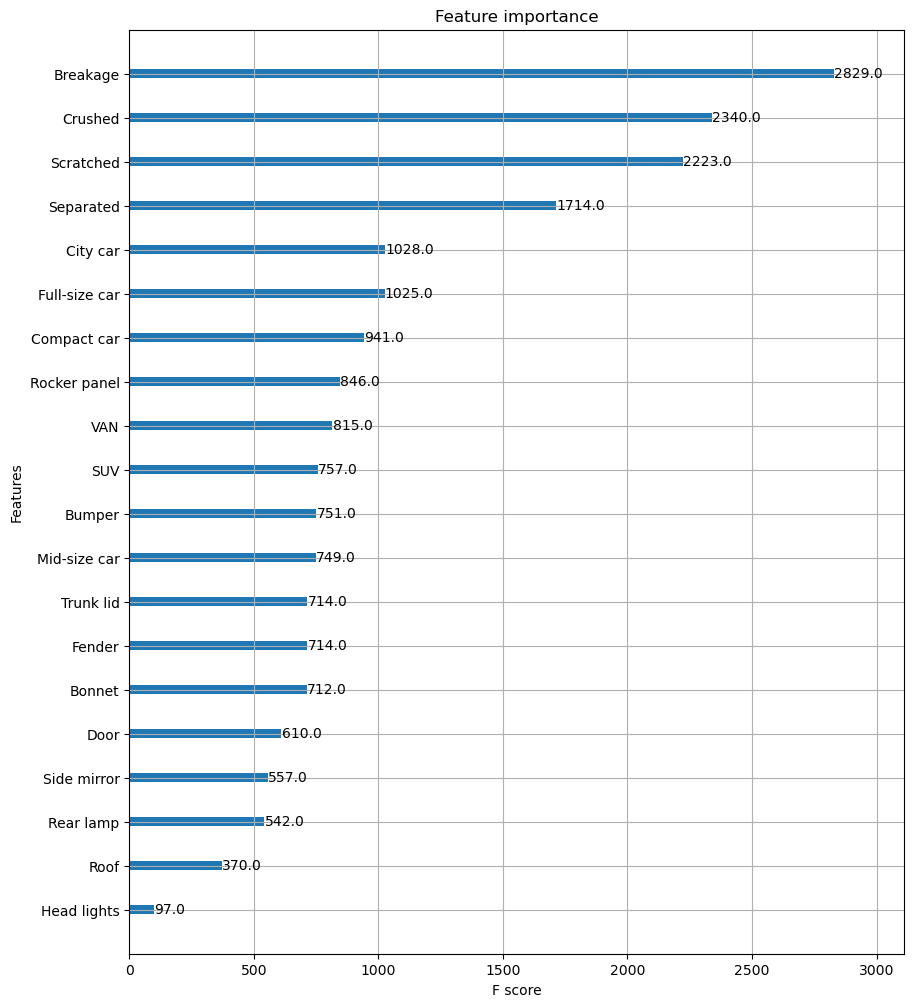

In [10]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

# Sheet_metal

In [37]:
X = sheet_metal[["part", "damage", "supercategory_name"]]
y = sheet_metal[["HQ"]]

X_dummy = pd.get_dummies(X)
X_dummy.columns = ['Bonnet', 'Bumper', 'Door', 'Fender', 'Head lights', 
                   'Rear lamp', 'Rocker panel', 'Roof', 'Side mirror', 
                   'Trunk lid', 'Wheel', 'Breakage', 'Crushed', 'Scratched', 
                   'Separated', 'City car', 'Compact car','Full-size car', 
                   'Mid-size car','SUV', 'VAN']
X_dummy.head()

X_train, X_test, y_train, y_test = train_test_split(X_dummy, y, test_size=.3, random_state=42, stratify=y)
print(len(X_train), len(X_test), len(y_train), len(y_test))

169338 72574 169338 72574


In [38]:
r_forest = RandomForestClassifier(max_depth=5).fit(X_train, y_train)

print("훈련용   :", r_forest.score(X_train, y_train))
print("테스트용 :", r_forest.score(X_test, y_test))

preds = r_forest.predict(X_test)
get_clf_eval(y_test, preds)

훈련용   : 0.48024660737696206
테스트용 : 0.4770992366412214
오차행렬:
 [[    0     4    13     0     0]
 [    0 13509 17350     0     0]
 [    0  7399 21116     0     0]
 [    0   769  9747     0     0]
 [    0   136  2531     0     0]]

정확도: 0.4771
정밀도: 0.2070
재현율: 0.2357
F1: 0.2091


In [39]:
# model save

joblib.dump(r_forest, 'HQ_sheet_metal_r_forest.h5')

loaded_model = joblib.load('HQ_sheet_metal_r_forest.h5')

score = loaded_model.score(X_dummy, y)
print('정확도: {score:.3f}'.format(score=score)) 

정확도: 0.479


### XGBoost

In [13]:
dtrain = xgb.DMatrix(data=X_train, label = y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

params = {
    'objective': 'multi:softmax',  # 다중 클래스 분류 문제 설정
    'num_class': 10,  # 클래스의 개수 설정
    'max_depth': 9,  # 트리의 깊이 설정
    'eta': 0.1,  # 학습률 설정
    'eval_metric': 'mlogloss'  # 평가 메트릭 설정
}

num_rounds = 100  # 학습 라운드 수 설정
wlist = [(dtrain, 'train'), (dtest,'eval')]

xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

[0]	train-mlogloss:2.14624	eval-mlogloss:2.14679
[1]	train-mlogloss:2.02392	eval-mlogloss:2.02487
[2]	train-mlogloss:1.92360	eval-mlogloss:1.92482
[3]	train-mlogloss:1.83904	eval-mlogloss:1.84047
[4]	train-mlogloss:1.76652	eval-mlogloss:1.76813
[5]	train-mlogloss:1.70349	eval-mlogloss:1.70527
[6]	train-mlogloss:1.64816	eval-mlogloss:1.65011
[7]	train-mlogloss:1.59923	eval-mlogloss:1.60132
[8]	train-mlogloss:1.55566	eval-mlogloss:1.55787
[9]	train-mlogloss:1.51669	eval-mlogloss:1.51900
[10]	train-mlogloss:1.48163	eval-mlogloss:1.48405
[11]	train-mlogloss:1.45000	eval-mlogloss:1.45250
[12]	train-mlogloss:1.42135	eval-mlogloss:1.42394
[13]	train-mlogloss:1.39531	eval-mlogloss:1.39799
[14]	train-mlogloss:1.37160	eval-mlogloss:1.37435
[15]	train-mlogloss:1.34995	eval-mlogloss:1.35277
[16]	train-mlogloss:1.33014	eval-mlogloss:1.33301
[17]	train-mlogloss:1.31196	eval-mlogloss:1.31490
[18]	train-mlogloss:1.29524	eval-mlogloss:1.29825
[19]	train-mlogloss:1.27986	eval-mlogloss:1.28291
[20]	train

In [14]:
preds = xgb_model.predict(dtest)
get_clf_eval(y_test, preds)

오차행렬:
 [[    0     7    10     0     0]
 [    0 15302 15542    15     0]
 [    0  9158 19323    30     4]
 [    0  1367  9112    34     3]
 [    0   309  2348    10     0]]

정확도: 0.4776
정밀도: 0.2769
재현율: 0.2353
F1: 0.2119


In [18]:
# model save

joblib.dump(r_forest, 'HQ_sheet_metal_xgb_model.h5')

loaded_model = joblib.load('HQ_sheet_metal_xgb_model.h5')

score = loaded_model.score(X_dummy, y)
print('정확도: {score:.3f}'.format(score=score)) 

정확도: 0.823


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

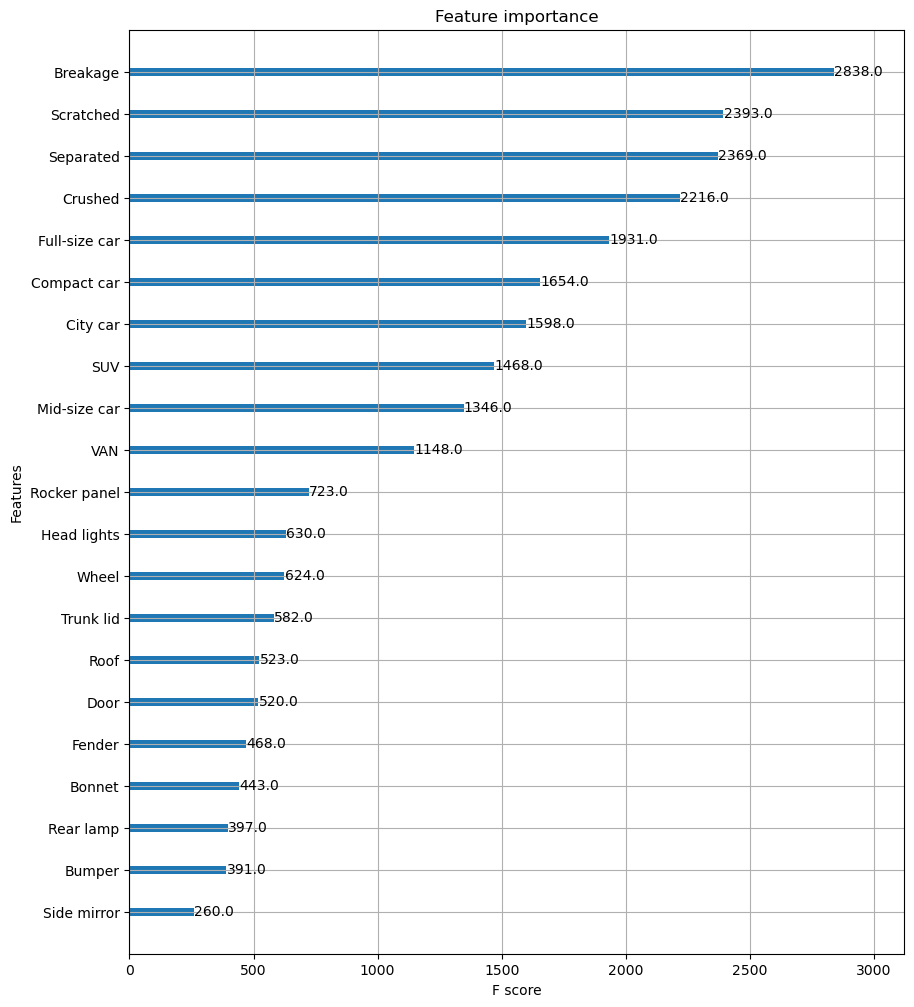

In [19]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

# Exchange

In [40]:
X = exchange[["part", "damage", "supercategory_name"]]
y = exchange[["HQ"]]

X_dummy = pd.get_dummies(X)
X_dummy.columns = ['Bonnet', 'Bumper', 'Door', 'Fender', 'Head lights', 
                   'Rear lamp', 'Rocker panel', 'Roof', 'Side mirror', 
                   'Trunk lid', 'Wheel', 'Breakage', 'Crushed', 'Scratched', 
                   'Separated', 'City car', 'Compact car','Full-size car', 
                   'Mid-size car','SUV', 'VAN']
X_dummy.head()

X_train, X_test, y_train, y_test = train_test_split(X_dummy, y, test_size=.3, random_state=42, stratify=y)
print(len(X_train), len(X_test), len(y_train), len(y_test))

347986 149137 347986 149137


### RandomForestClassifier

In [21]:
r_forest = RandomForestClassifier(max_depth=9).fit(X_train, y_train)

print("훈련용   :", r_forest.score(X_train, y_train))
print("테스트용 :", r_forest.score(X_test, y_test))

preds = r_forest.predict(X_test)
get_clf_eval(y_test, preds)

훈련용   : 0.8206680728535056
테스트용 : 0.8206816551224713
오차행렬:
 [[113121   2546   2813      0]
 [ 10530   4051   2433      0]
 [  6195   1376   5222      0]
 [    76      1    773      0]]

정확도: 0.8207
정밀도: 0.4608
재현율: 0.4003
F1: 0.4174


In [ ]:
# model save

joblib.dump(r_forest, 'HQ_exchange_r_forest.h5')

loaded_model = joblib.load('HQ_exchange_r_forest.h5')

score = loaded_model.score(X_dummy, y)
print('정확도: {score:.3f}'.format(score=score)) 

### XGBoost

In [22]:
dtrain = xgb.DMatrix(data=X_train, label = y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

params = {
    'objective': 'multi:softmax',  # 다중 클래스 분류 문제 설정
    'num_class': 10,  # 클래스의 개수 설정
    'max_depth': 9,  # 트리의 깊이 설정
    'eta': 0.1,  # 학습률 설정
    'eval_metric': 'mlogloss'  # 평가 메트릭 설정
}

num_rounds = 100  # 학습 라운드 수 설정
wlist = [(dtrain, 'train'), (dtest,'eval')]

xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

[0]	train-mlogloss:1.93107	eval-mlogloss:1.93110
[1]	train-mlogloss:1.69487	eval-mlogloss:1.69494
[2]	train-mlogloss:1.51843	eval-mlogloss:1.51852
[3]	train-mlogloss:1.37775	eval-mlogloss:1.37788
[4]	train-mlogloss:1.26148	eval-mlogloss:1.26162
[5]	train-mlogloss:1.16313	eval-mlogloss:1.16329
[6]	train-mlogloss:1.07864	eval-mlogloss:1.07881
[7]	train-mlogloss:1.00520	eval-mlogloss:1.00539
[8]	train-mlogloss:0.94083	eval-mlogloss:0.94102
[9]	train-mlogloss:0.88403	eval-mlogloss:0.88423
[10]	train-mlogloss:0.83365	eval-mlogloss:0.83386
[11]	train-mlogloss:0.78877	eval-mlogloss:0.78899
[12]	train-mlogloss:0.74865	eval-mlogloss:0.74888
[13]	train-mlogloss:0.71269	eval-mlogloss:0.71293
[14]	train-mlogloss:0.68038	eval-mlogloss:0.68062
[15]	train-mlogloss:0.65128	eval-mlogloss:0.65153
[16]	train-mlogloss:0.62504	eval-mlogloss:0.62529
[17]	train-mlogloss:0.60132	eval-mlogloss:0.60157
[18]	train-mlogloss:0.57987	eval-mlogloss:0.58012
[19]	train-mlogloss:0.56043	eval-mlogloss:0.56069
[20]	train

In [23]:
preds = xgb_model.predict(dtest)
get_clf_eval(y_test, preds)

오차행렬:
 [[110833   3820   3810     17]
 [  8184   5477   3326     27]
 [  5030   1330   6406     27]
 [     8      1    773     68]]

정확도: 0.8233
정밀도: 0.5864
재현율: 0.4595
F1: 0.4801


In [ ]:
# model save

joblib.dump(r_forest, 'HQ_exchange_xgb_model.h5')

loaded_model = joblib.load('HQ_exchange_xgb_model.h5')

score = loaded_model.score(X_dummy, y)
print('정확도: {score:.3f}'.format(score=score)) 

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)